<center><h1><strong>STYLE TRANSFER USING CONVOLUTION NEURAL NETWORK</strong></h1></center>

A style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. 

In the image below, the convolutional layers are named by stack and their order in the stack.
1. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. 
2.Conv_2_1 is the first convolutional layer in the *second* stack. 
3.The deepest convolutional layer in the network is conv_5_4.

![alt text](https://drive.google.com/uc?id=1_VvKZtUiqX0t7O_oy9301MiC3AECfWU1)

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

<h3>EXAMPLE</h3>

![](https://drive.google.com/uc?id=1Wmod-6Yne5CFImR2DVV0RT4rOmGj544d)

we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style _losses_ and use those to iteratively update our target image until we get a result that we want

In [ ]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [ ]:
# getting the "features" portion of VGG19
vgg = models.vgg19(pretrained=True).features

# freezing all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
### Load in Content and Style Images

# The `load_image` function also converts images to normalized Tensors.

def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [ ]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [ ]:
# load in content and style image
content = load_image('space_needle2.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('delaunay2.jpg', shape=content.shape[-2:]).to(device)

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))


FileNotFoundError: ignored

In [ ]:
 ## Run an image forward through a model and get the features for 
 ##       a set of layers. Default layers are for VGGNet matching Gatys et al (2016).
 
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [ ]:
##Calculate the Gram Matrix of a given tensor 

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram 

In [ ]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [ ]:
# weights for each style layer 
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  34635164.0


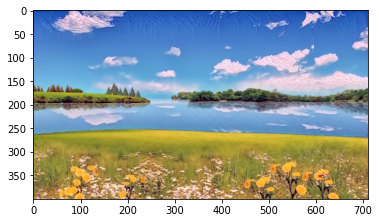

Total loss:  13096119.0


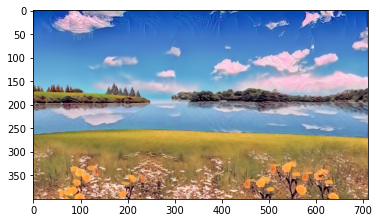

Total loss:  7640446.5


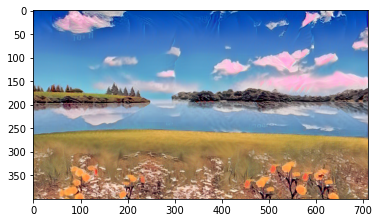

Total loss:  5298153.0


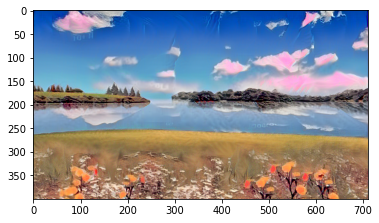

Total loss:  4003963.5


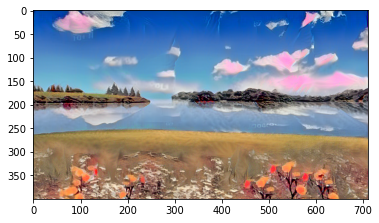

In [ ]:
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    style_loss = 0
    # then adding to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # updating your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # displaying intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

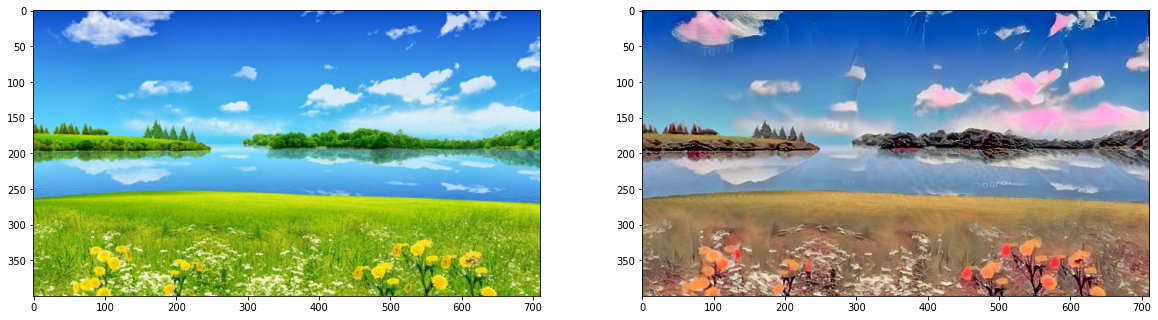

In [ ]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

**TESTCASES**


In [ ]:
from google.colab import files
content_image = files.upload()
target_image = files.upload()

Saving space_needle2.jpg to space_needle2.jpg


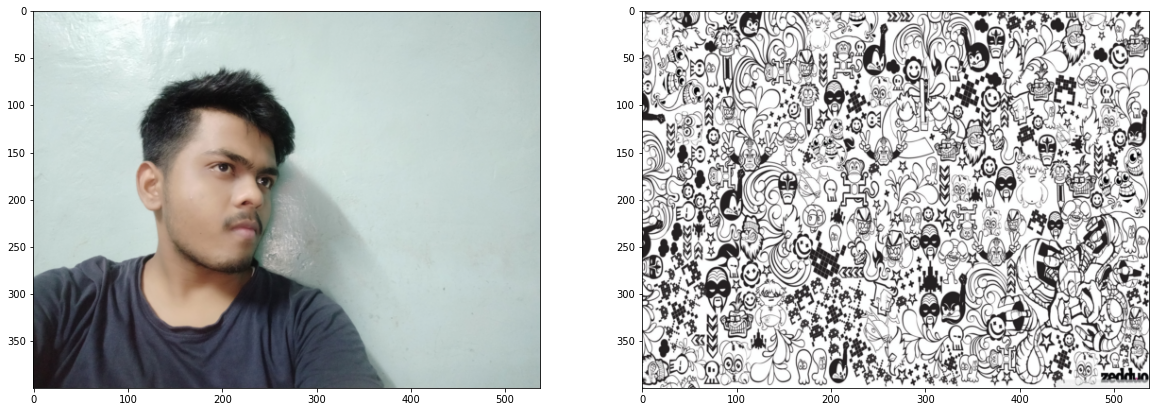

In [ ]:
content = load_image('space_needle2.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('delaunay2.jpg', shape=content.shape[-2:]).to(device)

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [ ]:
# for displaying the target image, intermittently
def predict(content_image,target_image):
  # get content and style features only once before training
  content_features = get_features(content_image, vgg)
  style_features = get_features(target_image, vgg)

  # calculate the gram matrices for each layer of our style representation
  style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

  # create a third "target" image and prep it for change
  # it is a good idea to start off with the target as a copy of our *content* image
  # then iteratively change its style
  target = content.clone().requires_grad_(True).to(device)
  show_every = 400

# iteration hyperparameters
  optimizer = optim.Adam([target], lr=0.003)
  steps = 2000  # decide how many iterations to update your image (5000)

  for ii in range(1, steps+1):
      
      # get the features from your target image
      target_features = get_features(target, vgg)
      
      # the content loss
      content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
      
      # the style loss
      # initialize the style loss to 0
      style_loss = 0
      # then add to it for each layer's gram matrix loss
      for layer in style_weights:
          # get the "target" style representation for the layer
          target_feature = target_features[layer]
          target_gram = gram_matrix(target_feature)
          _, d, h, w = target_feature.shape
          # get the "style" style representation
          style_gram = style_grams[layer]
          # the style loss for one layer, weighted appropriately
          layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
          # add to the style loss
          style_loss += layer_style_loss / (d * h * w)
          
      # calculate the *total* loss
      total_loss = content_weight * content_loss + style_weight * style_loss
      
      # update your target image
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
      
      # display intermediate images and print the loss
      if  ii % show_every == 0:
          print('Total loss: ', total_loss.item())
          plt.imshow(im_convert(target))
          plt.show()

    # display content and final, target image
  return content,target


Total loss:  34630200.0


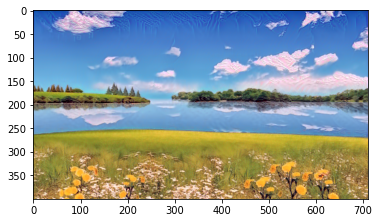

Total loss:  13097522.0


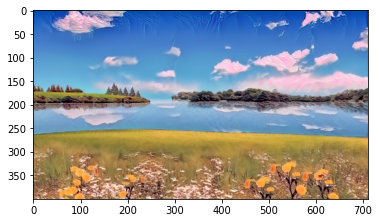

Total loss:  7637459.0


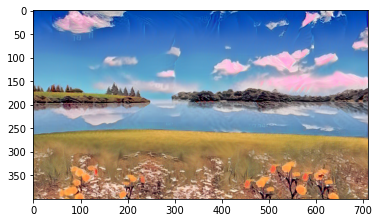

Total loss:  5297991.5


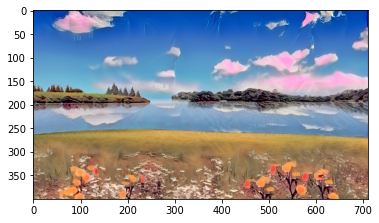

Total loss:  4009687.5


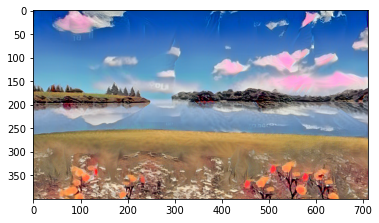

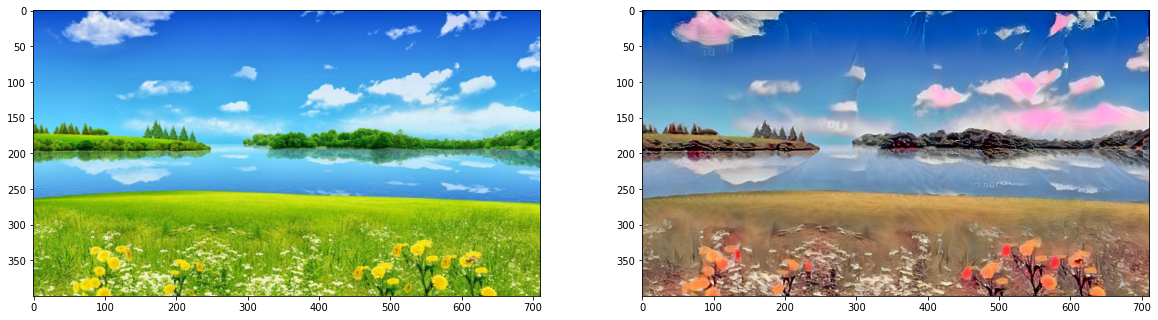

In [ ]:
content,target=predict(content,style)
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))


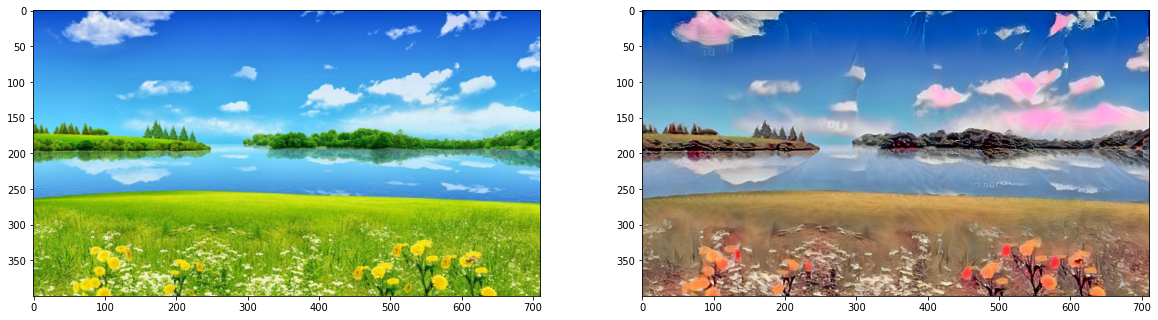

In [ ]:
 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))